In [386]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [387]:
def data_loader(path):
    # Load the CSV file
    file_path = os.path.join(os.getcwd(), path)  # Replace with your CSV file path
    data = pd.read_csv(file_path)

    # Preview the first few rows
    print(data.head())

    return data


def prepare_data(data, T_M1, T_M2,label, use_res = True):

    if not use_res:
        # First Method Results
        M1 = data['syn_method1'].dropna().values

        if T_M1 > M1.max():
            T_M1 = M1.max()
        elif T_M1 < M1.min():
            T_M1 = M1.min()

        # Replace `inf` values with finite max and min values
        finite_max = np.max(M1[np.isfinite(M1)])
        finite_min = np.min(M1[np.isfinite(M1)])


        # Replace positive infinity with the maximum finite value
        M1 = np.where(M1 == np.inf, finite_max, M1)
        # Replace negative infinity with the minimum finite value
        M1 = np.where(M1 == -np.inf, finite_min, M1)

        # Apply log transformation to reduce the range of extreme values
        positive_data_mask = M1 > 0
        M1[positive_data_mask] = np.log1p(M1[positive_data_mask])

        # Clip extreme values to reduce skewness
        lower_percentile = np.percentile(M1, 5)
        upper_percentile = np.percentile(M1, 95)
        M1 = np.clip(M1, lower_percentile, upper_percentile)

        M1_min_val = 0.2347169071435928
        M1_max_val = 1.22e+38

        normalized_M1 = normalize(M1, M1_min_val, M1_max_val)
        normalized_T_M1 = normalize(np.log1p(T_M1), M1_min_val, M1_max_val)

        M1_predict = (normalized_M1 < normalized_T_M1)

    else:
        M1 = data['syn_res'].dropna().values
        normalized_M1 = M1
        normalized_T_M1 = T_M1

        M1_predict = (normalized_M1 > normalized_T_M1)

    # Second Method Results
    M2 = data['syn_PSNR'].dropna().values

    # Normalize M2 to [0, 1]
    M2_min_val = np.min(M2)
    M2_max_val = np.max(M2)

    normalized_M2 = normalize(M2, M2_min_val, M2_max_val)
    normalized_T_M2 = normalize(T_M2, M2_min_val, M2_max_val)



    M2_predict = (normalized_M2 > normalized_T_M2)

    n_confilict = sum(M1_predict ^ M2_predict)

    

    accuracy_M1 = np.mean(M1_predict == label)
    accuracy_M2 = np.mean(M2_predict == label)




    print(f'First method error: {(len(M1_predict) - sum(M1_predict))}/{len(M1_predict)}, Accuracy: {accuracy_M1*100} %')
    print(f'second method error: {(len(M2_predict) - sum(M2_predict))}/{len(M2_predict)}, Accuracy: {accuracy_M2*100} %')
    print(f'number of confilict samples: {n_confilict}/{len(M1_predict)}, {n_confilict/len(M1_predict) * 100} %')


    conf_indices = np.where(M1_predict ^ M2_predict == True)[0]

    conf_H1 = M1_predict[conf_indices]
    conf_H2 = M2_predict[conf_indices]

    print(f'number of errors in confilicted samples for First method: {len(conf_H1) - sum(conf_H1)}/{n_confilict}')
    print(f'number of errors in confilicted samples for second method: {len(conf_H2) - sum(conf_H2)}/{n_confilict}')


    return normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices



def conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, label,T_unified = 0.5, use_res = True):
    # Conflict Handling
    conf_M1 = normalized_M1[conf_indices]
    conf_M2 = normalized_M2[conf_indices]

    if use_res:
        M1_conf_pred = (conf_M1 > normalized_T_M1)
    else:
        M1_conf_pred = (conf_M1 < normalized_T_M1)
    M2_conf_pred = (conf_M2 > normalized_T_M2)

    unified_conf,_,_ = unified_confidence(conf_M1 
                                  , conf_M2
                                  , normalized_T_M1
                                  , normalized_T_M2)

    decision = classify(unified_conf, T_unified) # 1: in-distribution, 0: out-of-distribution



    # Plot unified confidence and results
    plt.figure(figsize=(14, 8))
    plt.plot(unified_conf, label="Unified Confidence", marker="o", linestyle="--", color="blue")
    plt.axhline(y=T_unified, color='blue', linestyle='--', label=f"Unified Threshold ({T_unified})")

    # Overlay decisions for Method 1
    plt.scatter(range(len(M1_conf_pred)), conf_M1, label="Method 1 Results", marker="x", color="green")
    plt.axhline(y=normalized_T_M1, color='green', linestyle='--', label=f"Method 1 Threshold ({normalized_T_M1})")

    # Overlay decisions for Method 2
    plt.scatter(range(len(M2_conf_pred)), conf_M2, label="Method 2 Results", marker="s", color="red")
    plt.axhline(y=normalized_T_M2, color='red', linestyle='--', label=f"Method 2 Threshold ({normalized_T_M2})")

    # Annotations for decisions
    for i in range(len(unified_conf)):
        plt.annotate(decision[i], (i, unified_conf[i] + 0.02), fontsize=8, color="blue")
        plt.annotate(M1_conf_pred[i], (i, conf_M1[i] + 0.02), fontsize=8, color="green")
        plt.annotate(M2_conf_pred[i], (i, conf_M2[i] + 0.02), fontsize=8, color="red")

    # Labels and legend
    plt.xlabel("Sample Index")
    plt.ylabel("Confidence / Normalized Value")
    plt.title("Unified Confidence and Method Results")
    plt.legend()
    plt.grid()
    plt.show()


    # Metrics for validation
    num_in_dis = np.sum(decision == 1)
    num_ood = np.sum(decision == 0)

    print(f"Total In-Distribution Samples: {num_in_dis}")
    print(f"Total Out-of-Distribution Samples: {num_ood}")

    print("-------------------------------------------------------------------------------------------------")

    # Correlation between Method 1 and unified confidence
    corr_M1, _ = pearsonr(M1_conf_pred, unified_conf)
    print(f"Correlation between Method 1 and Unified Confidence: {corr_M1:.2f}")

    # Correlation between Method 2 and unified confidence
    corr_M2, _ = pearsonr(M2_conf_pred, unified_conf)
    print(f"Correlation between Method 2 and Unified Confidence: {corr_M2:.2f}")

    print("-------------------------------------------------------------------------------------------------")

    alignment_M1 = np.sum(decision == M1_conf_pred) / len(decision)
    alignment_M2 = np.sum(decision == M2_conf_pred) / len(decision)

    print(f"Alignment with Method 1 Decisions: {alignment_M1:.2f}")
    print(f"Alignment with Method 2 Decisions: {alignment_M2:.2f}")

    print("-------------------------------------------------------------------------------------------------")

    accuracy_M1 = np.mean(M1_conf_pred == label)
    accuracy_M2 = np.mean(M2_conf_pred == label)
    accuracy_unified = np.mean(decision == label)

    print(f"Accuracy of Method 1: {accuracy_M1*100:.2f} %")
    print(f"Accuracy of Method 2: {accuracy_M2*100:.2f} %")
    print(f"Accuracy of Unified Confidence: {accuracy_unified*100:.2f} %")

    print("-------------------------------------------------------------------------------------------------")

    if use_res:
        Final_decision = (normalized_M1 > normalized_T_M1)
    else:
        Final_decision = (normalized_M1 < normalized_T_M1)
    Final_decision[conf_indices] = decision

    accuracy_total = np.mean(Final_decision == label)
    print(f"Accuracy Hybrid Method: {accuracy_total * 100:.2f} %")

            



def normalize(data , min_val, max_val):
    return (data - min_val) / (max_val - min_val)


def unified_confidence(first_method_norm, psnr_norm, first_method_threshold=0.5, psnr_threshold=0.5):
    # Calculate confidence distances from thresholds
    first_distance = np.abs(first_method_norm - first_method_threshold)
    psnr_distance = np.abs(psnr_norm - psnr_threshold)
    
    # Calculate weights based on the distances (greater distance gets greater weight)
    w1 = first_distance / (first_distance + psnr_distance)
    w2 = psnr_distance / (first_distance + psnr_distance)
    
    # Combine the methods with their respective adaptive weights
    unified_conf = w1 * first_method_norm + w2 * psnr_norm
    
    # Normalize unified confidence to [0, 1]
    unified_conf = (unified_conf - np.min(unified_conf)) / (np.max(unified_conf) - np.min(unified_conf))
    
    return unified_conf, w1, w2

def classify(unified_conf, unified_threshold=0.5):
    return np.where(unified_conf > unified_threshold, True, False).astype(int)

exp with in distribution synthesised images - RealSR

In [388]:
data = data_loader('../results/stage2/Task3/exp6/results-6-RealSR-indis-degradation.csv')

       real_res  real_method1  real_PSNR   syn_res  syn_method1   syn_PSNR
0  1.105957e-02  3.253049e+01  20.117861  1.000000     0.364763  21.435759
1  8.907779e-28  4.027068e+26  21.083565  1.000000     0.294086  20.849812
2  7.129565e-27  4.749092e+25  21.585732  0.999997     0.304562  23.303940
3  1.314454e-13  2.733806e+12  20.319395  1.000000     0.319972  22.896101
4  0.000000e+00           inf  21.042841  1.000000     0.306958  21.507704


Using total prob

In [389]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=16, T_M2=21.72, use_res=False, label=1)

First method error: 0/300, Accuracy: 100.0 %
second method error: 71/300, Accuracy: 76.33333333333333 %
number of confilict samples: 71/300, 23.666666666666668 %
number of errors in confilicted samples for First method: 0/71
number of errors in confilicted samples for second method: 71/71


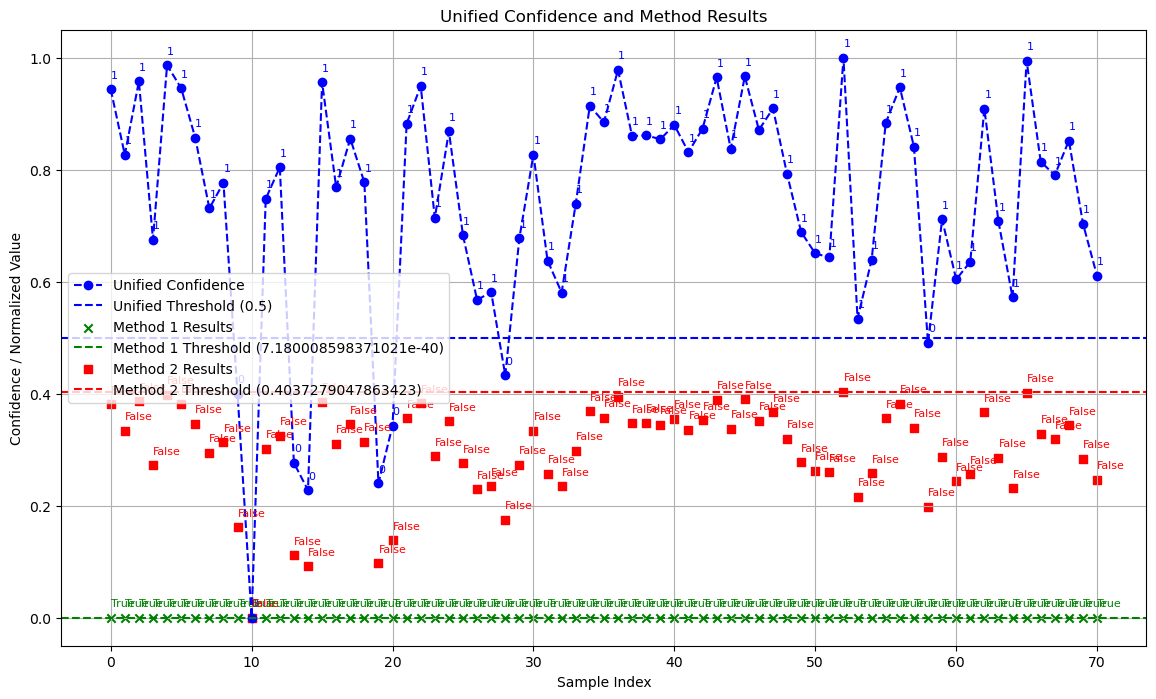

Total In-Distribution Samples: 63
Total Out-of-Distribution Samples: 8
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: nan
Correlation between Method 2 and Unified Confidence: nan
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.89
Alignment with Method 2 Decisions: 0.11
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 100.00 %
Accuracy of Method 2: 0.00 %
Accuracy of Unified Confidence: 88.73 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 97.33 %


C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:157: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M1, _ = pearsonr(M1_conf_pred, unified_conf)
C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M2, _ = pearsonr(M2_conf_pred, unified_conf)


In [390]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=False, label=1)

Using ResNet output

In [391]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=True, label=1)

First method error: 0/300, Accuracy: 100.0 %
second method error: 71/300, Accuracy: 76.33333333333333 %
number of confilict samples: 71/300, 23.666666666666668 %
number of errors in confilicted samples for First method: 0/71
number of errors in confilicted samples for second method: 71/71


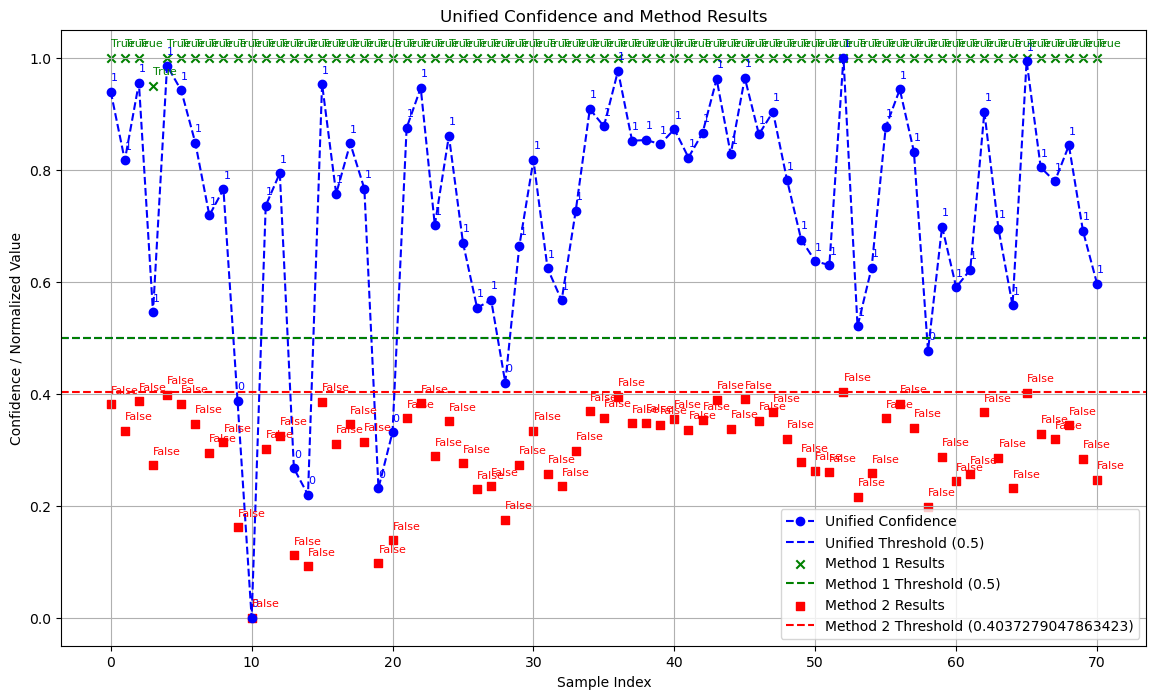

Total In-Distribution Samples: 63
Total Out-of-Distribution Samples: 8
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: nan
Correlation between Method 2 and Unified Confidence: nan
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.89
Alignment with Method 2 Decisions: 0.11
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 100.00 %
Accuracy of Method 2: 0.00 %
Accuracy of Unified Confidence: 88.73 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 97.33 %


C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:157: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M1, _ = pearsonr(M1_conf_pred, unified_conf)
C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M2, _ = pearsonr(M2_conf_pred, unified_conf)


In [392]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=True, label=1)


_______________________________________________________________________________________________________________________________________________________________________________________

exp with ISP synthesised images - RealSR

In [393]:
data = data_loader('../results/stage2/Task3/exp4/results-4-RealSR-ISP.csv')

       real_res  real_method1  real_PSNR       syn_res   syn_method1  \
0  1.610000e-18  2.060000e+17  21.348249  6.610000e-11  5.162163e+09   
1  2.830000e-19  1.550000e+18  21.472483  9.250000e-20  4.770000e+18   
2  4.270000e-21  9.410000e+19  23.602402  5.020000e-22  8.070000e+20   
3  2.900000e-20  1.260000e+19  20.843119  7.950000e-11  4.862582e+09   
4  1.350000e-23  3.270000e+22  21.026669  1.120000e-17  3.660000e+16   

    syn_PSNR  
0  22.394560  
1  20.717978  
2  21.764612  
3  20.908752  
4  18.690039  


In [394]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=16, T_M2=21.72, use_res=False, label=0)

First method error: 256/300, Accuracy: 85.33333333333334 %
second method error: 242/300, Accuracy: 80.66666666666666 %
number of confilict samples: 76/300, 25.333333333333336 %
number of errors in confilicted samples for First method: 45/76
number of errors in confilicted samples for second method: 31/76


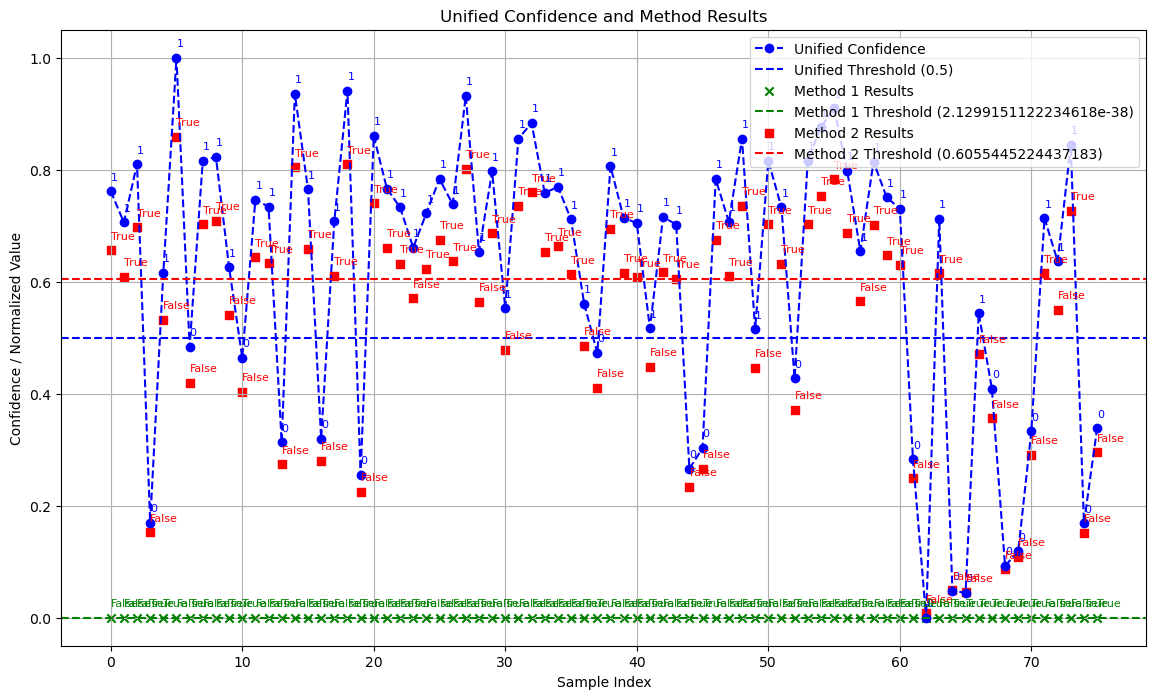

Total In-Distribution Samples: 56
Total Out-of-Distribution Samples: 20
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: -0.82
Correlation between Method 2 and Unified Confidence: 0.82
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.14
Alignment with Method 2 Decisions: 0.86
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 59.21 %
Accuracy of Method 2: 40.79 %
Accuracy of Unified Confidence: 26.32 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 77.00 %


In [395]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=False, label=0)

Using ResNet output

In [396]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=True, label=0)

First method error: 270/300, Accuracy: 90.0 %
second method error: 242/300, Accuracy: 80.66666666666666 %
number of confilict samples: 68/300, 22.666666666666664 %
number of errors in confilicted samples for First method: 48/68
number of errors in confilicted samples for second method: 20/68


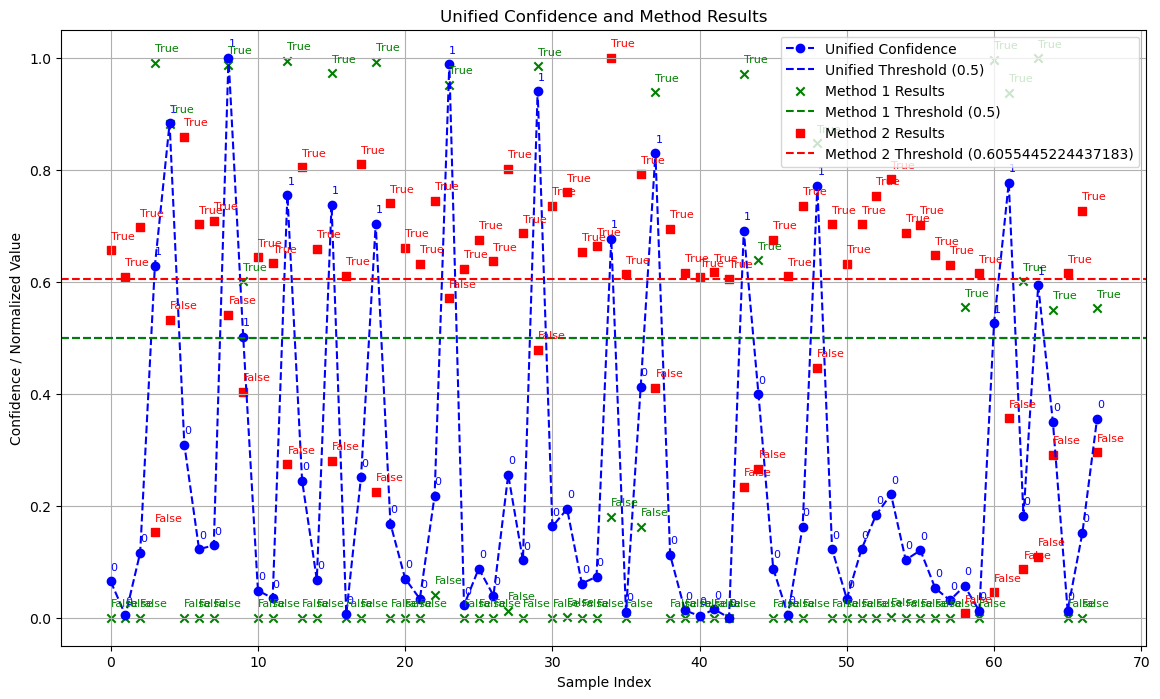

Total In-Distribution Samples: 16
Total Out-of-Distribution Samples: 52
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: 0.81
Correlation between Method 2 and Unified Confidence: -0.81
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.91
Alignment with Method 2 Decisions: 0.09
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 70.59 %
Accuracy of Method 2: 29.41 %
Accuracy of Unified Confidence: 76.47 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 91.33 %


In [397]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=True, label=0)

_______________________________________________________________________________________________________________________________________________________________________________________

exp with ISP synthesised images - DRealSR

In [398]:
data = data_loader('../results/stage2/Task3/exp5/results-5-DRealSR-ISP.csv')

       real_res  real_method1  real_PSNR       syn_res   syn_method1  \
0  0.000000e+00           inf  22.500175  0.000000e+00           inf   
1  6.800000e-37  3.810000e+35  25.116064  0.000000e+00           inf   
2  3.019121e-01  1.101793e+00  25.396482  1.866665e-01  1.802464e+00   
3  4.070000e-26  1.200000e+25  19.025160  6.099626e-01  5.365124e-01   
4  2.500000e-15  1.550070e+14  17.913340  9.230000e-16  4.142680e+14   

    syn_PSNR  
0  24.976562  
1  24.562439  
2  14.397435  
3  15.656560  
4  17.990141  


In [399]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=False, label=0)

First method error: 86/92, Accuracy: 93.47826086956522 %
second method error: 61/92, Accuracy: 66.30434782608695 %
number of confilict samples: 31/92, 33.69565217391305 %
number of errors in confilicted samples for First method: 28/31
number of errors in confilicted samples for second method: 3/31


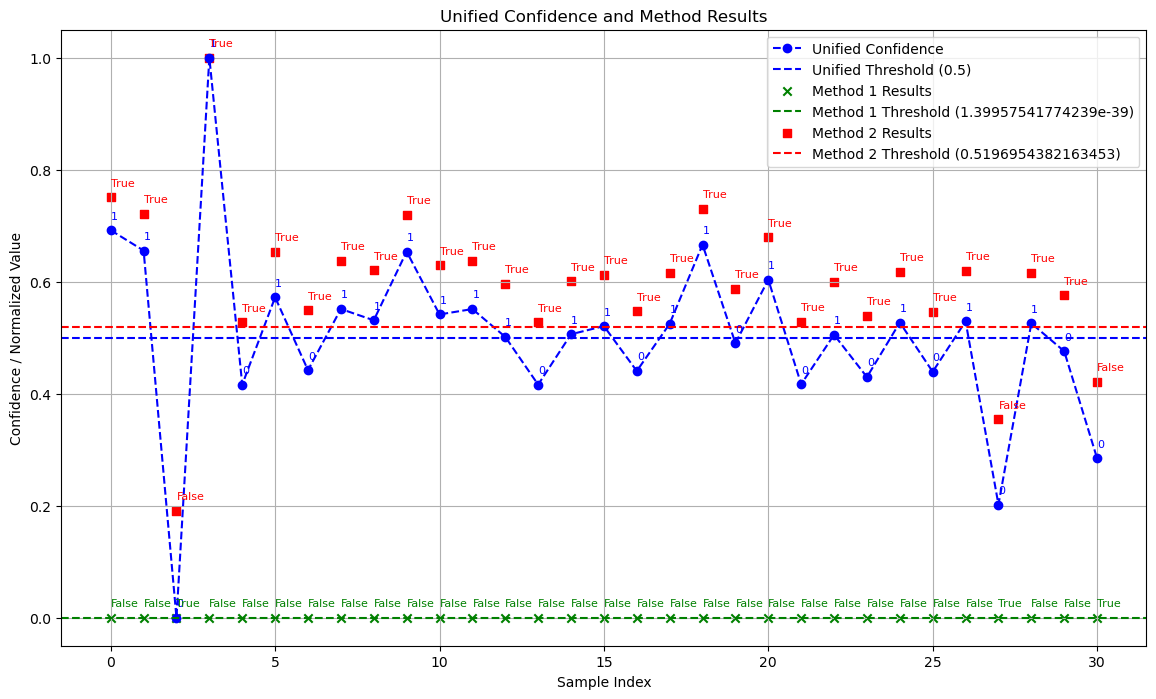

Total In-Distribution Samples: 19
Total Out-of-Distribution Samples: 12
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: -0.69
Correlation between Method 2 and Unified Confidence: 0.69
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.29
Alignment with Method 2 Decisions: 0.71
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 90.32 %
Accuracy of Method 2: 9.68 %
Accuracy of Unified Confidence: 38.71 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 76.09 %


In [400]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=False, label=0)

Using ResNet output

In [401]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=True, label=0)

First method error: 86/92, Accuracy: 93.47826086956522 %
second method error: 61/92, Accuracy: 66.30434782608695 %
number of confilict samples: 33/92, 35.869565217391305 %
number of errors in confilicted samples for First method: 29/33
number of errors in confilicted samples for second method: 4/33


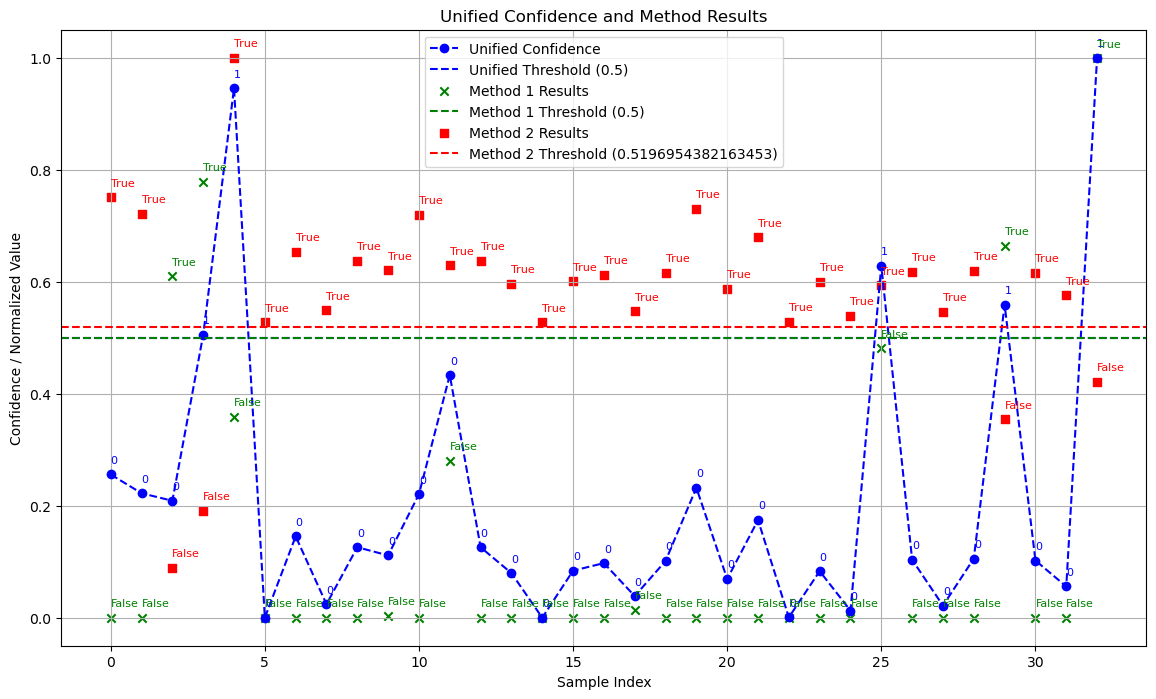

Total In-Distribution Samples: 5
Total Out-of-Distribution Samples: 28
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: 0.54
Correlation between Method 2 and Unified Confidence: -0.54
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.91
Alignment with Method 2 Decisions: 0.09
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 87.88 %
Accuracy of Method 2: 12.12 %
Accuracy of Unified Confidence: 84.85 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 92.39 %


In [402]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=True, label=0)

_______________________________________________________________________________________________________________________________________________________________________________________

exp with in distribution synthesised images - DRealSR

In [403]:
data = data_loader('../results/stage2/Task3/exp7/results-7-DRealSR-indis-degradation.csv')

       real_res  real_method1  real_PSNR   syn_res  syn_method1   syn_PSNR
0  0.000000e+00           inf  20.577028  1.000000     0.327647  27.140165
1  8.252466e-22  4.355516e+20  19.422697  1.000000     0.284056  25.283247
2  2.115038e-31  1.389764e+30  19.296976  1.000000     0.313011  22.285669
3  0.000000e+00           inf  22.278061  0.999997     0.356153  22.889391
4  1.587918e-14  2.096329e+13  21.551987  1.000000     0.319602  27.163910


In [404]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=False, label=1)

First method error: 0/92, Accuracy: 100.0 %
second method error: 5/92, Accuracy: 94.56521739130434 %
number of confilict samples: 5/92, 5.434782608695652 %
number of errors in confilicted samples for First method: 0/5
number of errors in confilicted samples for second method: 5/5


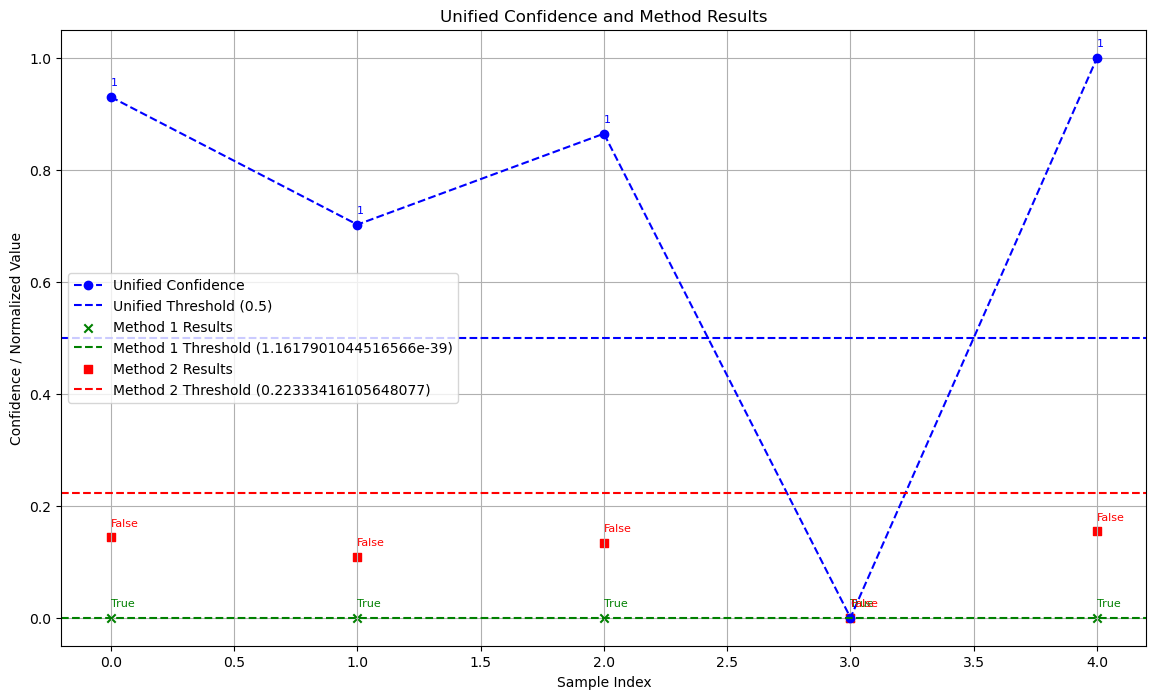

Total In-Distribution Samples: 4
Total Out-of-Distribution Samples: 1
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: nan
Correlation between Method 2 and Unified Confidence: nan
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.80
Alignment with Method 2 Decisions: 0.20
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 100.00 %
Accuracy of Method 2: 0.00 %
Accuracy of Unified Confidence: 80.00 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 98.91 %


C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:157: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M1, _ = pearsonr(M1_conf_pred, unified_conf)
C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M2, _ = pearsonr(M2_conf_pred, unified_conf)


In [405]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=False, label=1)

Using ResNet output

In [406]:
normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices = prepare_data(data, T_M1=0.5, T_M2=21.72, use_res=True, label=1)

First method error: 0/92, Accuracy: 100.0 %
second method error: 5/92, Accuracy: 94.56521739130434 %
number of confilict samples: 5/92, 5.434782608695652 %
number of errors in confilicted samples for First method: 0/5
number of errors in confilicted samples for second method: 5/5


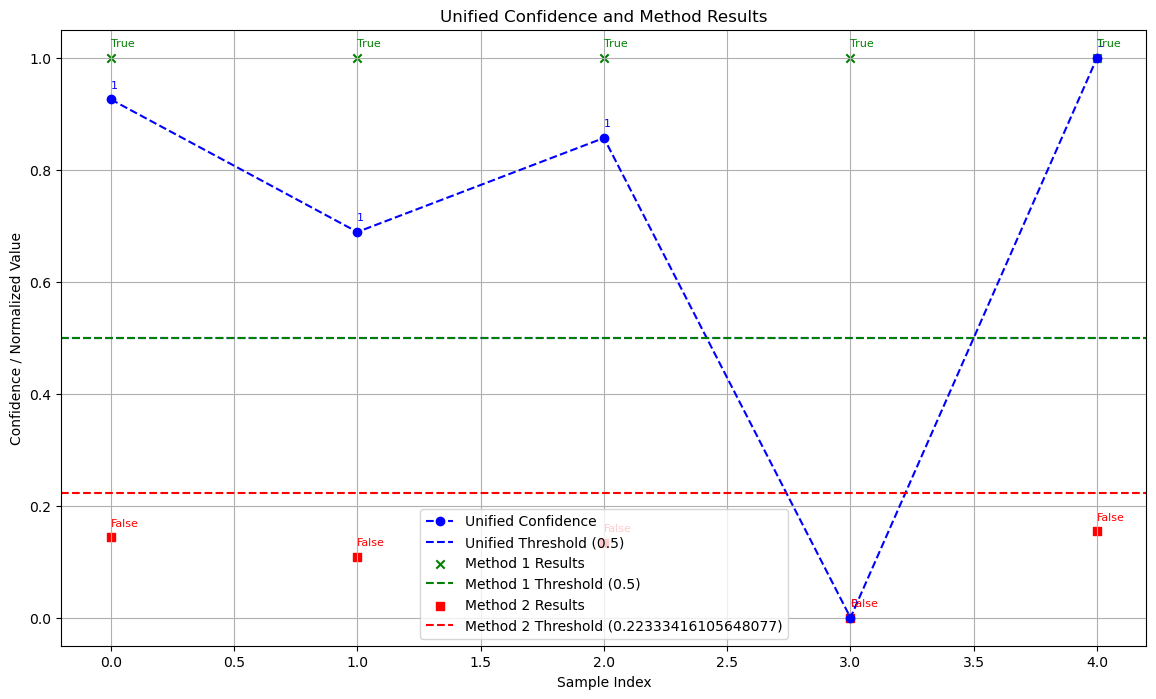

Total In-Distribution Samples: 4
Total Out-of-Distribution Samples: 1
-------------------------------------------------------------------------------------------------
Correlation between Method 1 and Unified Confidence: nan
Correlation between Method 2 and Unified Confidence: nan
-------------------------------------------------------------------------------------------------
Alignment with Method 1 Decisions: 0.80
Alignment with Method 2 Decisions: 0.20
-------------------------------------------------------------------------------------------------
Accuracy of Method 1: 100.00 %
Accuracy of Method 2: 0.00 %
Accuracy of Unified Confidence: 80.00 %
-------------------------------------------------------------------------------------------------
Accuracy Hybrid Method: 98.91 %


C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:157: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M1, _ = pearsonr(M1_conf_pred, unified_conf)
C:\Users\Saher andishe\AppData\Local\Temp\ipykernel_10284\1016066496.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_M2, _ = pearsonr(M2_conf_pred, unified_conf)


In [407]:
conflict_handle(normalized_M1, normalized_M2, normalized_T_M1, normalized_T_M2, conf_indices, use_res=True, label=1)